# Welcome to scikit-tda tutorial

This notebook will be available on the project's page [scikit-tda.org](https://scikit-tda.org/).

# Features of scikit-tda
 
+ a simple **python** interface to fast C/C++ libraries
+ **easy** to install, **easy** to use
+ **flexible inputs**: n-dimensional data, abstract metric spaces, graphs
+ part of **scikit-learn** family of python tools for data analysis


# scikit-tda install

```shell 
pip install scikit-tda
```

# scikit-tda modules
* **Kepler Mapper** &mdash; mapper algorithm
* **Ripser** &mdash; persistence homology computations
* **Persim** &mdash; comparison and analysis of persistence diagrams
* **CechMate** &mdash; advanced and custom filtrations
* **TaDAsets** &mdash; synthetic data sets of some manifolds (shperes, torus, swiss rolls)



# Outline of this notebook
1. In this notebook we focus on the persistence tools of **scikit-tda**: **ripser** and **persim**. 
2. We start with an overview of the API required to produce persistence diagrams. 
3. Then we will take a look at some tools for analysing PDs availablale in **scikit-tda**.
4. And finally, we will take a look at application of persistence homology to graphs of chemical interactions.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. Persistence API

At first, let's generate a toy example. 
```tadasets``` has few functions to generate random point clouds of different shapes. 
Below we generate two samples of size ```n=100``` from 1-spheres: 
* ```data_clean``` data is sampled directly from a unit cirle
* ```data_noisy``` data is sampled from a unit circle with add standard normal noise scaled by ```noise``` parameter.

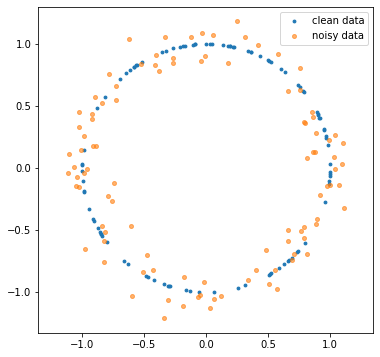

In [2]:
import tadasets
np.random.seed(565656)

data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
data_noisy = tadasets.dsphere(d=1, n=100, noise=0.10) 

# data_clean = tadasets.infty_sign(n=100, noise=0.0)
# data_noisy = tadasets.infty_sign(n=100, noise=0.15) 

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data", s=8)
plt.scatter(data_noisy[:,0], data_noisy[:,1], label="noisy data", s=16, alpha=0.6)
plt.axis('equal')
plt.legend()
plt.show()

## 1.1. Computing and ploting persistence diagrams for point cloud data

* To compute the PD of a point cloud we are using **ripser** module. Either directly or via an object of ```Rips``` class
* To plot PDs we use **persim** module.
* **ripser** can take a distance matrix as input


### 1.1.1. Out of the box persistence

In [3]:
import ripser
import persim

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

In [4]:
# ripser.ripser(data_clean)

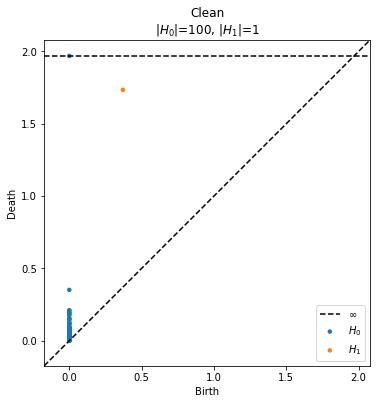

In [5]:
dgm_clean = ripser.ripser(data_clean)['dgms']
persim.plot_diagrams(
    dgm_clean, 
    show=True, 
    title=f"Clean\n{diagram_sizes(dgm_clean)}"
) 

### 1.1.2. Class interface

The **Ripser** module also provides a *sklearn*-style class ```Rips```.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


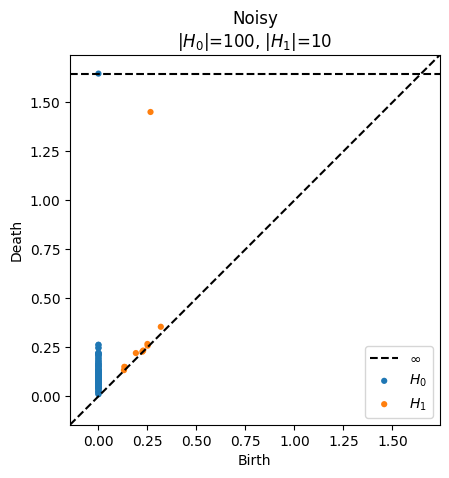

In [6]:
from ripser import Rips
rips = Rips()
dgm_noisy = rips.transform(data_noisy)
rips.plot(show=True, title=f"Noisy\n{diagram_sizes(dgm_noisy)}") 

### 1.1.3. Input option: Distance matrix
An important feature of **Ripser** is its ability to take distance matrices as input. This flexiblity allwos **Ripser** to handle n-dimensional point clouds as well as more abstract metric spaces, for example, given by graphs.


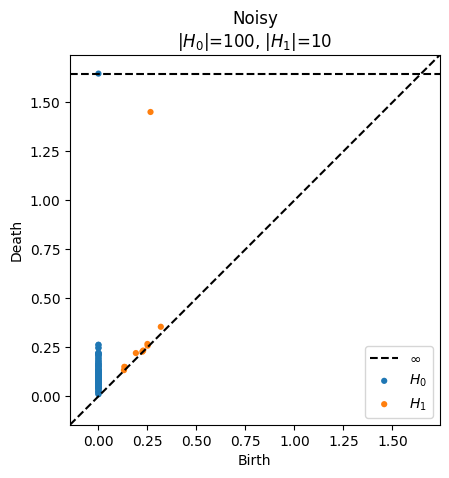

In [7]:
from sklearn.metrics.pairwise import pairwise_distances

D = pairwise_distances(data_noisy, metric='euclidean')

dgm_noisy = ripser.ripser(D, distance_matrix=True)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True, 
    title=f"Noisy\n{diagram_sizes(dgm_noisy)}"
) 

## 1.2. Ripser's options
* ```maxdim: int``` &mdash; maximum homology dimension computed
* ```thresh: float``` &mdash; maximum radius for Rips filtration
* ```coeff: int``` &mdash; field of coefficients of homology 
 

### 1.2.1. Maximum homology dimension 
* 0 &mdash; points, $H_0 \equiv $ connected components
* 1 &mdash; line segments, $H_1 \equiv$ holes
* 2 &mdash; triangles, $H_2 \equiv$ cavities

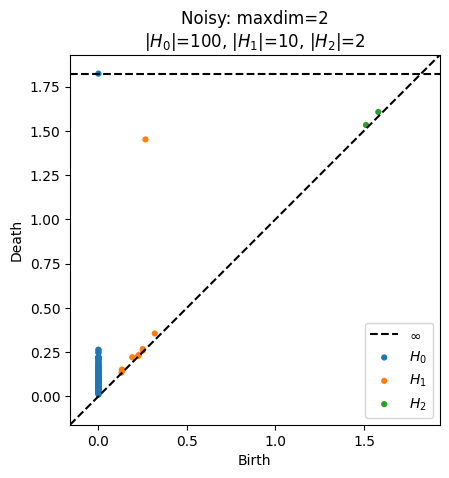

In [8]:
dgm_noisy = ripser.ripser(data_noisy, maxdim=2)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True, 
    title=f"Noisy: maxdim=2\n{diagram_sizes(dgm_noisy)}"
) 

### 1.2.2. Maximum Radius for Rips filtration
**Vietoris–Rips complex**, also called the *Vietoris complex* or *Rips complex*, is a way of forming a topological space from distances in a set of points. 
It is an abstract simplicial complex that contains a simplex for every finite set of points that has diameter at most $R$:
- if a finite set $S$ of $k$ points has the property that the distance between every pair of points in $S$ is at most $R$, then we include $S$ as a ($k-1$)-simplex in the complex.

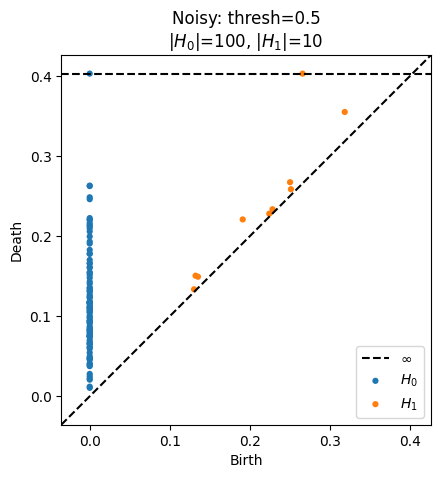

In [9]:
thresh = 0.5
dgm_noisy = ripser.ripser(data_noisy, thresh=thresh)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True, 
    title=f"Noisy: thresh={thresh}\n{diagram_sizes(dgm_noisy)}"
) 

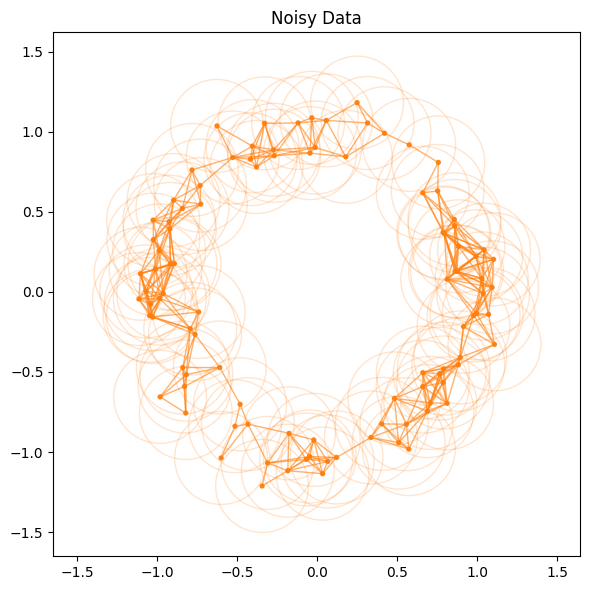

In [10]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

def plot_rips_complex(data, R, label="data", col=1, maxdim=2):
    tab10 = cm.get_cmap('tab10')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(label)
    ax.scatter(
        data[:, 0], data[:, 1], label=label,
        s=8, alpha=0.9, c=np.array(tab10([col] * len(data)))
    )

    for xy in data:
        ax.add_patch(mpatches.Circle(xy, radius=R, fc='none', ec=tab10(col), alpha=0.2))

    for i, xy in enumerate(data):
        if maxdim >=1:
            for j in range(i + 1, len(data)):
                pq = data[j]
                if (xy != pq).all() and (np.linalg.norm(xy - pq) <= R):
                    pts = np.array([xy, pq])
                    ax.plot(pts[:, 0], pts[:, 1], color=tab10(col), alpha=0.6, linewidth=1)
                if maxdim == 2:
                    for k in range(j + 1, len(data)):
                        ab = data[k]
                        if ((ab != pq).all()
                                and (np.linalg.norm(xy - pq) <= R)
                                and (np.linalg.norm(xy - ab) <= R)
                                and (np.linalg.norm(pq - ab) <= R)
                        ):
                            pts = np.array([xy, pq, ab])
                            ax.fill(pts[:, 0], pts[:, 1], facecolor=tab10(col), alpha=0.1)
                        pass

    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    pass

plot_rips_complex(data_noisy, R=0.29, label="Noisy Data", maxdim=1)

### 1.2.3. Ripser's options for the class interface
When an object of the ```Rips``` class is used, the options are set as fields of the ripser object.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


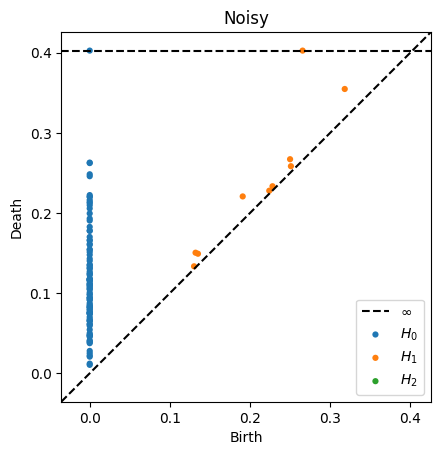

In [11]:
rips = Rips()
rips.maxdim = 2
rips.thresh = 0.5
rips.coef = 3
rips.transform(data_noisy)
rips.plot(show=True, title='Noisy') 

## 1.3. Plotting options
* persistence diagrams of different data sets on one plot
* customizing the plot:, ```xy_range```, ```title: str```, ```size: str```, 
* ```lifetime```
* persistence images

### 1.3.1. PDs of different data sets on one plot

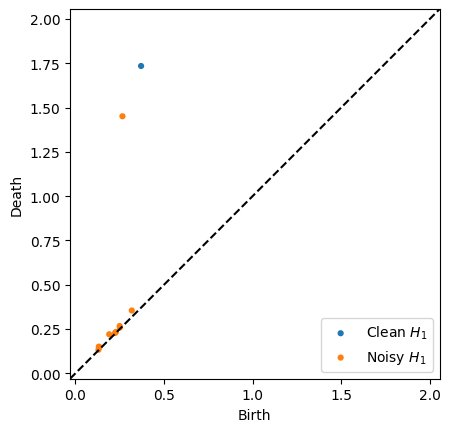

In [12]:
dgms_clean = ripser.ripser(data_clean)['dgms']
dgms_noisy = ripser.ripser(data_noisy, maxdim=2)['dgms']
persim.plot_diagrams(
    [dgms_clean[1], dgms_noisy[1]], 
    labels=['Clean $H_1$', 'Noisy $H_1$'], 
    show=True
)

### 1.3.2. Customizing plot

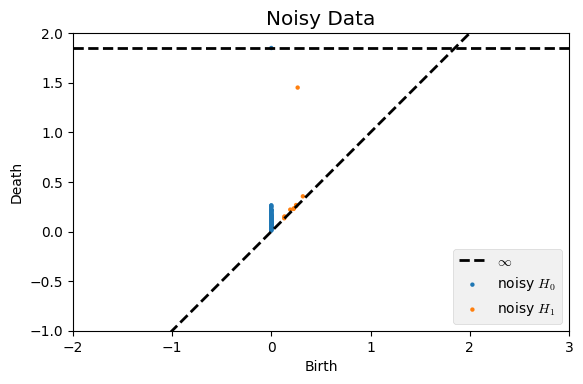

In [13]:
persim.plot_diagrams(
    dgms_noisy, 
    title="Noisy Data",
    labels=["noisy $H_0$", "noisy $H_1$"],
    colormap="bmh",
    xy_range=[-2,3, -1, 2],
    size=10,
    diagonal=True,
    show=True
)

### 1.3.3. Lifetime plots

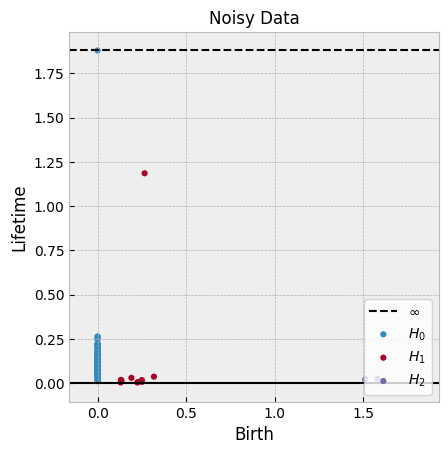

In [14]:
persim.plot_diagrams(
    dgms_noisy, 
    title="Noisy Data",
    lifetime=True,
    show=True
)

### 1.3.4. Persistence images
The **Persim** module contains class ```PersistenceImager``` that is a transformer which converts persistence diagrams into persistence images.

<AxesSubplot:title={'center':'Persistence Image'}, xlabel='birth', ylabel='persistence'>

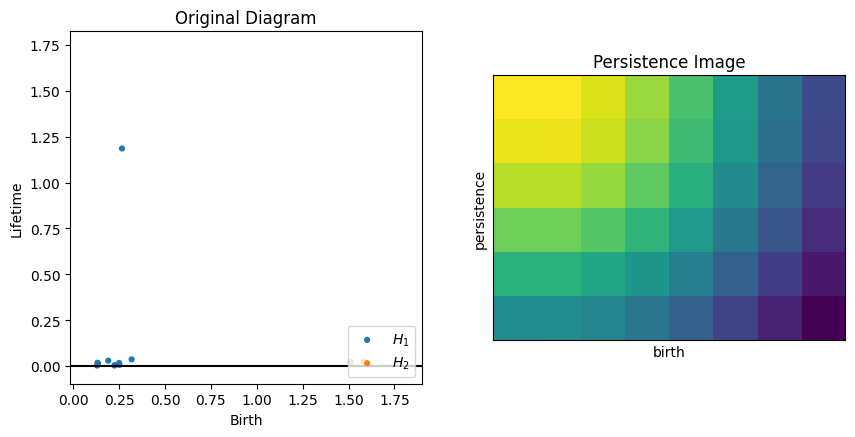

In [15]:
from persim import PersistenceImager

pimager = PersistenceImager(pixel_size=0.2)

# The `fit()` method can be called on one or more (*,2) numpy arrays 
# to automatically determine the miniumum birth and persistence ranges needed to capture all persistence pairs. 
# The ranges and resolution are automatically adjusted to accomodate the specified pixel size.
pimager.fit(dgms_noisy[1:3])

# The `transform()` method can then be called on one or more (*,2) numpy arrays 
# to generate persistence images from diagrams.
imgs = pimager.transform(dgms_noisy[1:3])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].set_title("Original Diagram")
persim.plot_diagrams(dgms_noisy[1:3],  lifetime=True, ax=axs[0], labels=["$H_1$", "$H_2$"])

axs[1].set_title("Persistence Image")
pimager.plot_image(imgs[0], ax=axs[1])

# 2. Analysis  of PDs

## 2.1. Distance between diagrams
**persim** package contains implementations of a number of distance functions between persistence diagrams:
* Wasserstein distance with matching between persistence diagrams.
* *Bottleneck* distance with matching between persistence diagrams.
* Estimation of Gromov-Hausdorff distance.
* The pseudo-metric between two diagrams based on the continuous heat kernel.

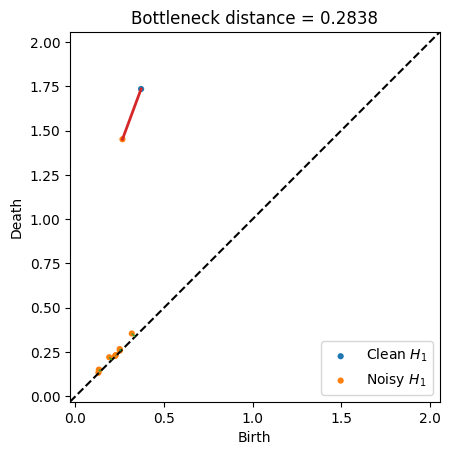

In [16]:
dgm_clean = ripser.ripser(data_clean)['dgms'][1]
dgm_noisy = ripser.ripser(data_noisy)['dgms'][1]

# The bottleneck of the matching is shown as a red line, 
# while the other pairs in the perfect matching which are less than the diagonal are shown as green lines 
# (NOTE: There may be many possible matchings with the minimum bottleneck, and this returns an arbitrary one)
distance_bottleneck, matching = persim.bottleneck(dgm_clean, dgm_noisy, matching=True)
persim.bottleneck_matching(
    dgm_clean, dgm_noisy, matching, 
    labels=['Clean $H_1$', 'Noisy $H_1$']
)
plt.title(f"Bottleneck distance = {distance_bottleneck:0.4f}",)
plt.show()

## 2.2. Persistence Images in Classification 

* We construct datasets from two classes, one just *noise* and the other *noise with two circles* in the middle. 
* We then compute persistence diagrams with **ripser**.
* In order to apply ML algorithms, we need to vectorize computed PDs. We do this by converting them into persistence images with **PersIm**. 
* Using these persistence images, we build a Logistic Regression model using a LASSO penatly to classify whether the dataset has a circle or not.

### 2.2.1. Data

We start by generating $M$ point clouds each of size $N$: 
half of them are noise, another half are noise with circles.

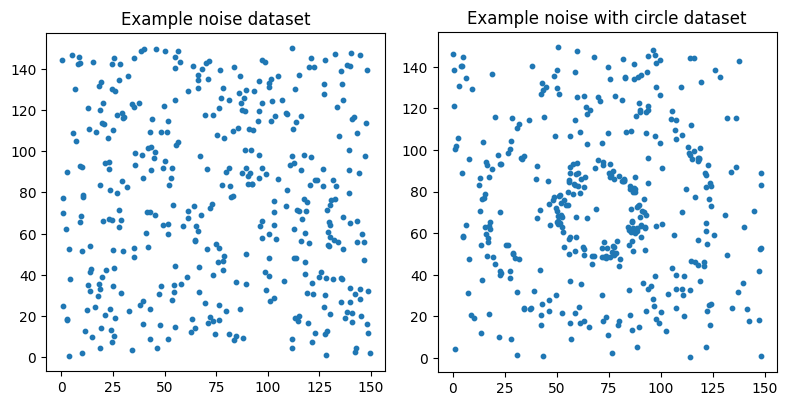

In [17]:
np.random.seed(565656)
M = 50           # total number of samples
m = int(M / 2)   # number of samples per class ('noise'/'circles')
N = 400          # number of points per dataset

def noise(N, scale):
    return scale * np.random.random((N, 2))

def circle(N, scale, offset):
    """Generates two circles with center at `offset` scaled by `scale`"""
    half = int(N/2)
    circ = np.concatenate(
        (tadasets.dsphere(d=1, n=half, r=1.1, noise=0.05),
        tadasets.dsphere(d=1, n=N-half, r=0.4, noise=0.05))
    )
    return offset + scale * circ

# Generate data
just_noise = [noise(N, 150) for _ in range(m)]

half = int(N / 2)
with_circle = [np.concatenate((circle(half, 50, 70), noise(N - half, 150)))
               for _ in range(m)]

datas = []
datas.extend(just_noise)
datas.extend(with_circle)

# Define labels
labels = np.zeros(M)
labels[m:] = 1

# Visualize the data
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8,4)

xs, ys = just_noise[0][:,0], just_noise[0][:,1]
axs[0].scatter(xs, ys, s=10)
axs[0].set_title("Example noise dataset")
axs[0].set_aspect('equal', 'box')

xs_, ys_ = with_circle[0][:,0], with_circle[0][:,1]
axs[1].scatter(xs_, ys_, s=10)
axs[1].set_title("Example noise with circle dataset")
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

### 2.2.2. Persistence Diagrams

For each point cloud we generate a $H_1$ persistence diagramm.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


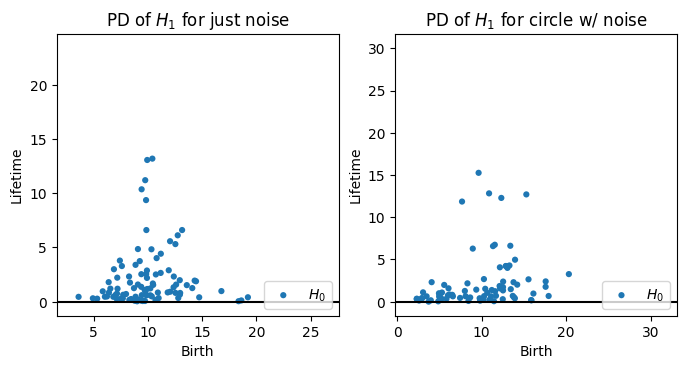

In [18]:
rips = ripser.Rips(maxdim=1, coeff=2)
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]

plt.figure(figsize=(8,4))

plt.subplot(121)
rips.plot(diagrams_h1[0], show=False, lifetime=True)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h1[-1], show=False, lifetime=True)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

### 2.2.3. Persistence Images

Next, each persistence diagram is turned into a persistence image, which is just a 2d-array of pixels. 

PI Resolution = (33, 23)


Text(0.5, 1.0, 'PI of $H_1$ for circle w/ noise')

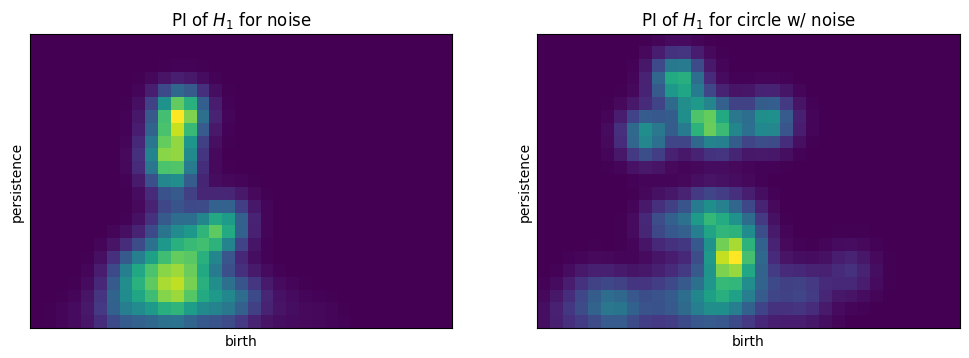

In [19]:
pimgr = PersistenceImager(pixel_size=0.8)
pimgr.fit(diagrams_h1)
imgs = pimgr.transform(diagrams_h1)
print(f"PI Resolution = {pimgr.resolution}")

plt.figure(figsize=(12, 7))
ax = plt.subplot(121)
pimgr.plot_image(imgs[0], ax)
plt.title("PI of $H_1$ for noise")

ax = plt.subplot(122)
pimgr.plot_image(imgs[-1], ax)
plt.title("PI of $H_1$ for circle w/ noise")

### 2.2.4. Classification
Now, we flatten 2d-images into 1d-arrays and randomly split them into test and traing data sets. 

Finally, we fit Logistic Regression with a LASSO penatly to the training data, and compute mean accuracy on the test data.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# train/test data
imgs_array = np.array([img.flatten() for img in imgs])
X_train, X_test, y_train, y_test = train_test_split(
    imgs_array, labels, test_size=0.40, random_state=42
)
print(f"Train size = {X_train.shape[0]}\n"
      f"Test size  = {X_test.shape[0]} \n"
      f"Dimensions = {imgs_array.shape[1]}")

# logistic regression
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f"{'-'*35}\nTrain score = {train_score}; Test score={test_score}")

Train size = 30
Test size  = 20 
Dimensions = 759
-----------------------------------
Train score = 1.0; Test score=0.85


# 3. Persistence for graphs

*This work is done as part of my internship at PNNL.*

## 3.1. Species-reaction graph data

The graph below is a species-reaction graph and it represents an atmospheric chemical mechanisms, in particular the Super-Fast chemical mechanism (SF). 
* There are 18 chemicals and 20 reactions. It is a **bipartite** graph.
* Weights are linearly related to (log) rates of reactions and are **positive**.
* The graph is **directed**, but we will transform it into an undirected graph.


### 3.1.1. Reading graph data

In [21]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

# reading nodes
nodes = pd.read_csv(
    "data/sfNames.csv", 
    header=0, sep=" ", 
    dtype={'id': int, 'name': str}, 
)

nodes['isRxn'] = nodes['name'].str.contains("Rxn").astype(int)
nodes["name"] = nodes['name'].str.replace("Rxn: ", "").str.replace(" ", "")
nodes["color"] = pd.Series(pd.Categorical.from_codes(nodes["isRxn"], categories=["cyan", "orange"]))
nodes = nodes.set_index('id', drop=False)

# reading edges
edges = pd.read_csv(
    "data/sfEdgeWeights.csv", 
    header=0, sep=" ", 
    dtype=dict(source=int, target=int, weight=float), 
)

# create a bipartite graph
G = nx.from_pandas_edgelist(edges, create_using=nx.DiGraph, edge_attr=True,)
nx.set_node_attributes(G, nodes['isRxn'].to_dict(), "bipartite")
print(f"is bipartite = {bipartite.is_bipartite(G)}")

is bipartite = True


### 3.1.2. Plot graph and weight histogram

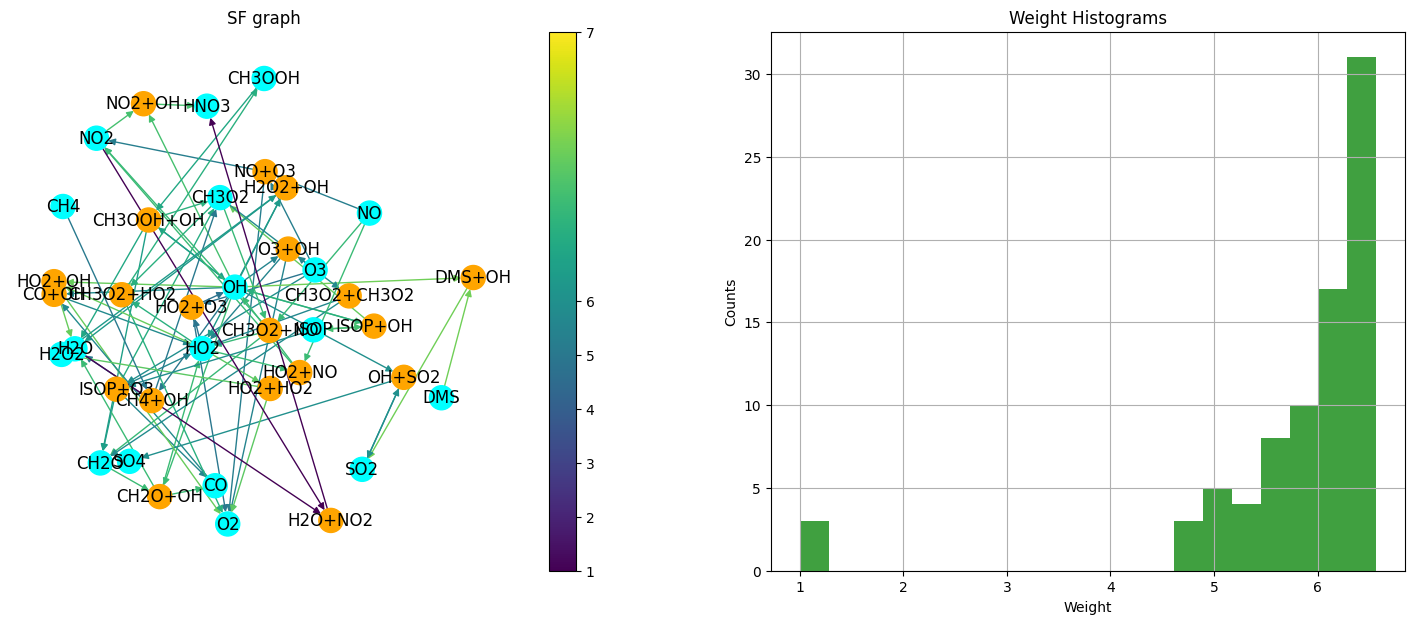

In [22]:
# edge weights
G_weights = [e[2]['weight'] for e in G.edges.data()]

# plot graph
norm = colors.TwoSlopeNorm(
    vcenter=round(np.mean(G_weights)),
    vmin=round(min(G_weights)),
    vmax=round(max(G_weights))
)
virdis_cmap = cm.get_cmap('viridis')
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
axs[0].set_title("SF graph")    
nx.draw(
    G, ax=axs[0], 
    pos=nx.spring_layout(G, scale=80, k=2), 
    labels=nodes['name'].to_dict(),
    node_color=nodes['color'].loc[list(G)].to_list(),
    edge_color=virdis_cmap(norm(G_weights)),
    with_labels=True,
)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=virdis_cmap), ax=axs[0])

# plot weight histogram
axs[1].hist(G_weights, bins=20, facecolor='g', alpha=0.75)
axs[1].set_title("Weight Histograms")
axs[1].set_xlabel("Weight")
axs[1].set_ylabel("Counts")
axs[1].grid()

plt.show()

## 3.2. Persistance based on the adjacency matrix

Basically, our goal is to construct a distance matrix out of the weighted adjacency matrix (non-zero entries correspond to edge weights).

Let $G = (N, E)$ be an **undirected** graph.
For any two nodes $n, m \in N$ we define distance between them as:

\begin{align*}
%----------------------------------------------------------------------------------------------
    d(n, m) &= 
    \begin{cases}
        \infty, &\text{ if } (n, m) \notin E \\
        w(n, m) > 0, 
                &\text{ if }  (n, m) \in E \\
        0,      &\text{ if } n = m
    \end{cases}
%----------------------------------------------------------------------------------------------
\end{align*}

In [23]:
G = nx.Graph(G)    # to undirected
A = nx.adjacency_matrix(G).copy().todense().astype(float)
A[A == 0] = np.inf
np.fill_diagonal(A, [0]*len(G))
A = np.array(np.round(A, 4))
print(f"is symmetric = {np.allclose(np.asarray(A.T), np.asarray(A))}")

is symmetric = True


Now, we can compute persistence diagrams for our graph.

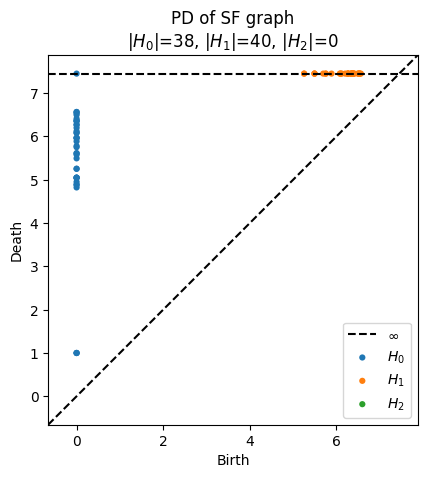

In [24]:
dgms = ripser.ripser(A, distance_matrix=True, maxdim=2)['dgms']
persim.plot_diagrams(
    dgms, show=True, 
    title=f"PD of SF graph\n{diagram_sizes(dgms)}"
) 

## 3.3. Persistance based on shortest paths

Similarly, we can use the shortest path distances between nodes to construct an abstract metric space. The length of a path can be given as the number of edges ($L_0$) or as the total length of its edges ($L_1$).

Note, that if the graph is directed then it is possible that **not all** nodes are reachable by a directed path from every other node (not strongly connected). In this case, as previously, we assign $\infty$ to be the distance between unreachable pairs of nodes.

In [25]:
# compute shortest path matrix
def get_path_distance_matrix(G, lnorm='L1'):
    L0 = lnorm == 'L0'
    L1 = lnorm == 'L1'
    node_idx = {n: i for i, n in enumerate(G.nodes)}
    D = np.full((len(G), len(G)), np.inf)
    for n, (dists, paths) in nx.all_pairs_dijkstra(G, weight='weight'):
        for k, dist in dists.items():
            D[node_idx[n], node_idx[k]] = dist if L1 else len(paths[k]) if L0 else 1
    return np.array(np.round(D, 4))

### 3.3.1. $L_1$ shortest path distance

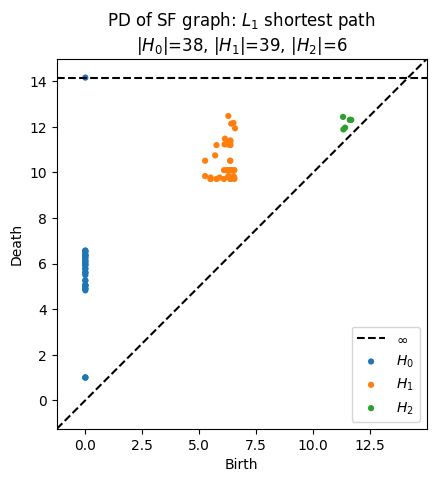

In [26]:
D1 = get_path_distance_matrix(G, lnorm='L1')
dgms_L1 = ripser.ripser(D1, distance_matrix=True, maxdim=2)['dgms']

persim.plot_diagrams(
    dgms_L1, show=True, 
    title=f"PD of SF graph: $L_1$ shortest path\n{diagram_sizes(dgms_L1)}"
) 

### 3.3.2. $L_0$ shortest path distance

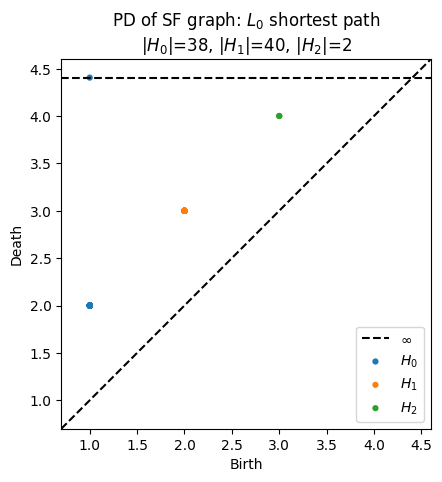

In [27]:
D0 = get_path_distance_matrix(G, lnorm='L0')
dgms_L0 = ripser.ripser(D0, distance_matrix=True, maxdim=2)['dgms']

persim.plot_diagrams(
    dgms_L0, show=True, 
    title=f"PD of SF graph: $L_0$ shortest path\n{diagram_sizes(dgms_L0)}"
) 

# Thank you!

That's it folks! 